In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, accuracy_score
import math

# Load Mast Data

We chose to go with the Risoe data, only loading the data that is needed, to reduce memory usage.

In [2]:
import netCDF4 as nc
import numpy as np
from datetime import datetime, timedelta

file_path_risoe = 'Data/Risoe/risoe_m_all.nc'
#file_paths_borglum = 'Data/Borglum/borglum_all.nc'

signals_risoe = ['ws77', 'wd77', 'ws125', 'wd125']
#signals_borglum = ['ws32', 'wd32']

base_date_risoe = datetime(1995, 11, 20, 16, 25, 0)
#base_date_borglum = datetime(1997, 12, 11, 16, 5, 0)

# Get the Risoe dataset:
mast_risoe = nc.Dataset(file_path_risoe, 'r')

# List the variables in the dataset
print("Variables in the netCDF file:")
for var_name in mast_risoe.variables:
    print(var_name)

time_minutes = np.array(mast_risoe.variables['time'])

# Convert time values to timestamp strings
time = []
for minutes in time_minutes:
	time_delta = timedelta(minutes=int(minutes))
	timestamp = base_date_risoe + time_delta
	time.append(timestamp.strftime('%Y-%m-%d %H:%M:%S'))
 
print(f"time:\n {time[:10]} - {time[-1]}")

for signal in signals_risoe:
	values = np.array(mast_risoe.variables[signal])
	print(f'{signal}:\n {values[:10]} - {values[-10:-1]}')

Variables in the netCDF file:
time
ws44
ws44_qc
ws77
ws77_qc
ws125
ws125_qc
wd77
wd77_qc
wd125
wd125_qc
t003
t003_qc
t044
t044_qc
t118
t118_qc
td01
td01_qc
rain
rain_qc
press
press_qc
rhum
rhum_qc
grad
grad_qc
time:
 ['1995-11-20 16:25:00', '1995-11-20 16:35:00', '1995-11-20 16:45:00', '1995-11-20 16:55:00', '1995-11-20 17:05:00', '1995-11-20 17:15:00', '1995-11-20 17:25:00', '1995-11-20 17:35:00', '1995-11-20 17:45:00', '1995-11-20 17:55:00'] - 2007-12-31 23:56:00
ws77:
 [3.36 3.05 3.59 3.87 4.74 4.91 4.98 5.39 5.76 5.52] - [8.14 8.71 6.82 7.26 7.24 6.04 6.97 8.17 6.66]
wd77:
 [205. 205. 204. 202. 201. 206. 203. 203. 193. 200.] - [0. 0. 0. 0. 0. 0. 0. 0. 0.]
ws125:
 [3.04 3.17 3.64 3.77 4.28 4.91 5.35 5.58 5.75 5.38] - [nan nan nan nan nan nan nan nan nan]
wd125:
 [208. 214. 209. 209. 212. 213. 210. 206. 207. 205.] - [0. 0. 0. 0. 0. 0. 0. 0. 0.]


Converting the data to a Pandas DataFrame, to make it easier to work with.
Converting time to datetime objects, and setting it as the index.

In [3]:
# convert mast_risoe to pandas dataframe

df_mast_risoe = pd.DataFrame()
df_mast_risoe['time'] = time
df_mast_risoe['ws77'] = np.array(mast_risoe.variables['ws77'])
df_mast_risoe['wd77'] = np.array(mast_risoe.variables['wd77'])
df_mast_risoe['ws125'] = np.array(mast_risoe.variables['ws125'])
df_mast_risoe['wd125'] = np.array(mast_risoe.variables['wd125'])

df_mast_risoe['time'] = pd.to_datetime(df_mast_risoe['time'])

df_mast_risoe.set_index('time', inplace=True)

# display last 25 rows
df_mast_risoe.tail(25)

,ws77,wd77,ws125,wd125
time,,,,
2007-12-31 19:56:00,8.20,0.0,NaN,0.0
2007-12-31 20:06:00,7.51,0.0,NaN,0.0
2007-12-31 20:16:00,8.15,0.0,NaN,0.0
2007-12-31 20:26:00,8.48,0.0,NaN,0.0
2007-12-31 20:36:00,8.36,0.0,NaN,0.0
2007-12-31 20:46:00,10.50,0.0,NaN,0.0
2007-12-31 20:56:00,9.34,0.0,NaN,0.0
2007-12-31 21:06:00,7.85,0.0,NaN,0.0
2007-12-31 21:16:00,7.39,0.0,NaN,0.0


# Handle missing values

First we plot all the data, to see if there are any missing values.

array([[<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>]], dtype=object)

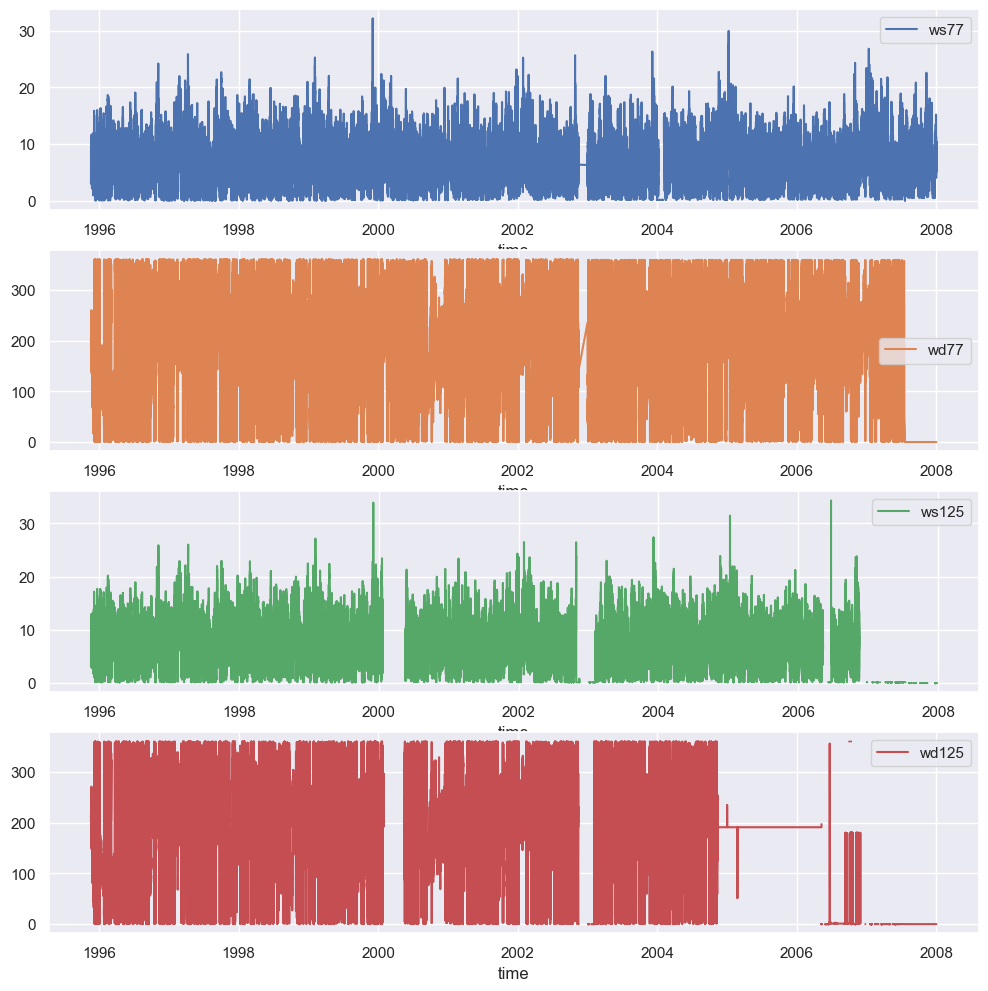

In [4]:
sns.set()
df_mast_risoe.plot(subplots=True, layout=(4,1), figsize=(12,12), sharex=False, sharey=False)

We chose to use height 77 to have more data points to work with.

Later we can try to do height 125 as well. There is less data but it will still be very relevant since the turbine blades are operating in a very large height range.

Checking for null values in the data.

In [5]:
df_mast_risoe.drop(inplace=True, columns=['wd125', 'ws125'])
df_mast_risoe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 628359 entries, 1995-11-20 16:25:00 to 2007-12-31 23:56:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ws77    621607 non-null  float64
 1   wd77    627811 non-null  float64
dtypes: float64(2)
memory usage: 14.4 MB


Displaying the distribution of the wind direction data.

<Axes: xlabel='wd77'>

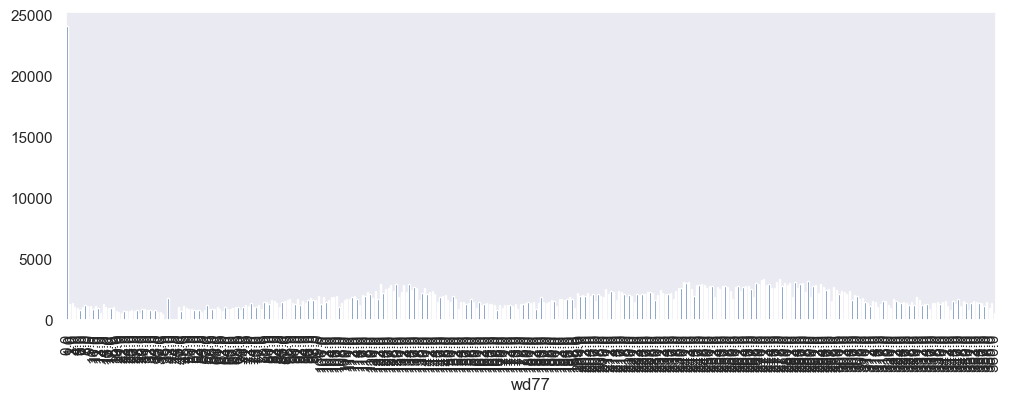

In [6]:
df_mast_risoe['wd77'].value_counts().sort_index().plot(kind='bar', figsize=(12,4), grid=False)

Remove the last part of data where the wind direction is missing i.e. 0.0 for a long period of time

In [7]:
series = pd.Series(df_mast_risoe['wd77'])
non_zero = series.to_numpy().nonzero()
last_non_zero = non_zero[0][-1]

# remove all values after last non-zero value
df_mast_risoe = df_mast_risoe.iloc[:last_non_zero+1]

Doing a visual inspection of the data again to see results after removing missing values.

array([[<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>]], dtype=object)

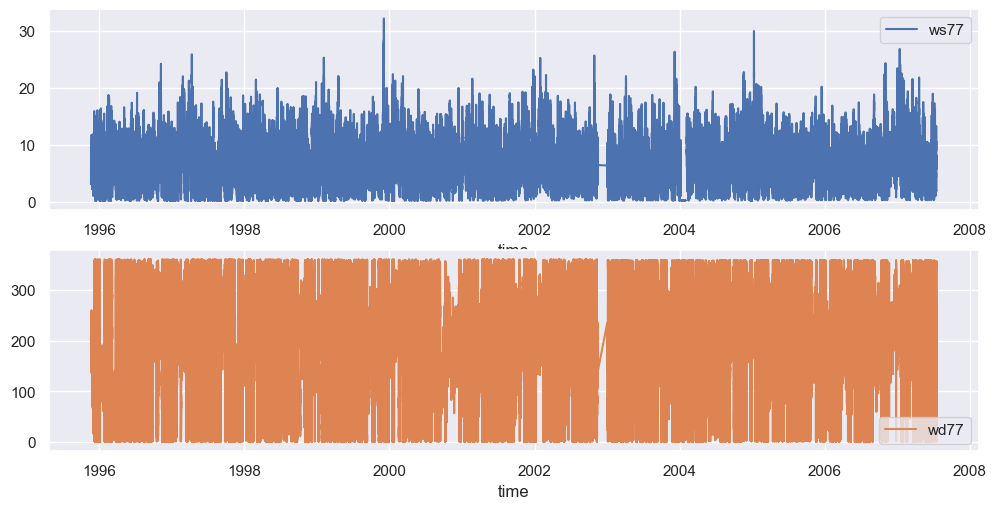

In [8]:
sns.set()
df_mast_risoe.plot(subplots=True, layout=(4,1), figsize=(12,12), sharex=False, sharey=False)

Plotting a smaller part of the windspeed to get a better look at missing data

<Axes: xlabel='time'>

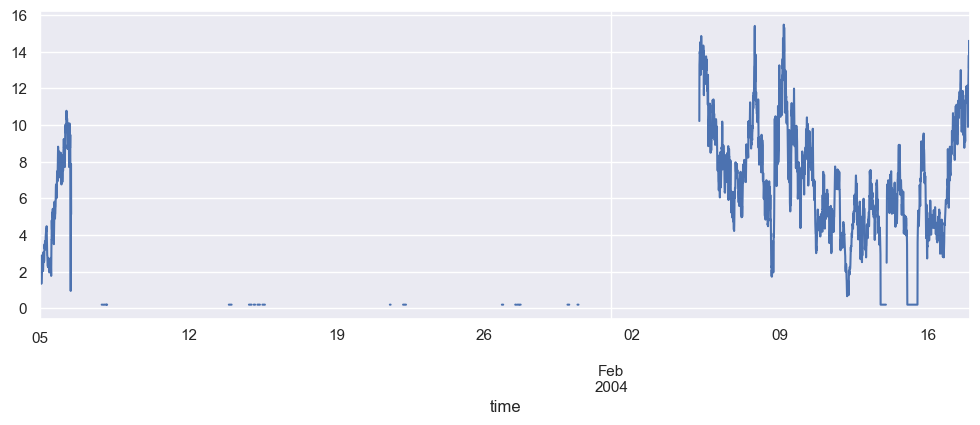

In [9]:
# plot the first 2 months of ws77 from the start of 2004

df_mast_risoe['2004-01-05':'2004-02-17']['ws77'].plot(figsize=(12,4), grid=True)

Trying to display the missing data in a different way. To see if there were a lot of 0.0 measurements, but it is a lot of 0.2 which might still be valid. We acnt tell wince we do not have domain knowledge.

<Axes: xlabel='ws77'>

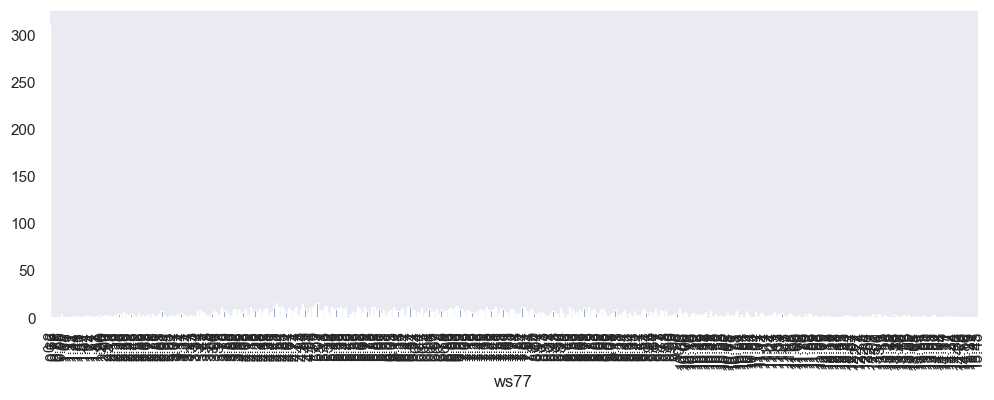

In [10]:
df_mast_risoe['2004-01-05':'2004-02-17']['ws77'].value_counts().sort_index().plot(kind='bar', figsize=(12,4), grid=False)

Showing amount of null values again

In [11]:
df_mast_risoe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604917 entries, 1995-11-20 16:25:00 to 2007-07-15 23:40:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ws77    598165 non-null  float64
 1   wd77    604369 non-null  float64
dtypes: float64(2)
memory usage: 30.0 MB


Doing a zoomed in view on lowest values, to try and get a better understanding of the data. This really doesnt help us much, since we do not know if 0.01 is a valid value or not. And the lovest value changes over time, could be due to different hardware beign used, or different strategies of doucumenting still standing wind or missing values.

<Axes: xlabel='time'>

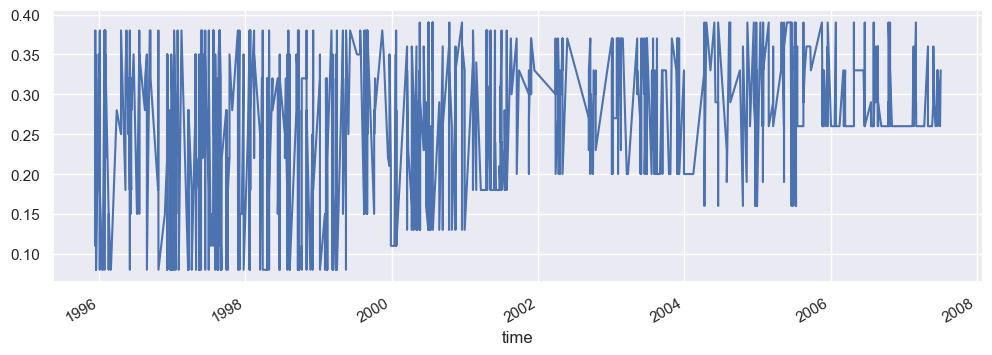

In [12]:
# plot all values where ws77 is less than 0.1

df_mast_risoe[df_mast_risoe['ws77'] < 0.4]['ws77'].plot(figsize=(12,4), grid=True)

One of the previous graphs are displaying some missing values for the wind speed. We are then creating wind speed measurements that are taken as the average of the same date and time from all other measurements that are available in the data

Creating placeholder columns for dates to make it possible to do the transformation.

In [13]:
df_mast_risoe['date_month_day_hour'] = df_mast_risoe.index.strftime('%m-%d %H')
df_mast_risoe['minute_first_digit'] = df_mast_risoe.index.minute // 10
df_mast_risoe['ws77'].fillna(df_mast_risoe.groupby(['date_month_day_hour', 'minute_first_digit'])['ws77'].transform('mean'), inplace=True)

After the transformation we remove the help columns again

In [14]:
df_mast_risoe.drop(['date_month_day_hour', 'minute_first_digit'], axis=1, inplace=True)

After the transformation we take another look at the place where there were missing wind speed data. This shows us that it might not have been the best approach since it just almost just gives an average wind speed over the period. We chose to go forward with this approach since it is the best we can do with the data we have. It is not that long of a period so will not affect the data that much.

<Axes: xlabel='time'>

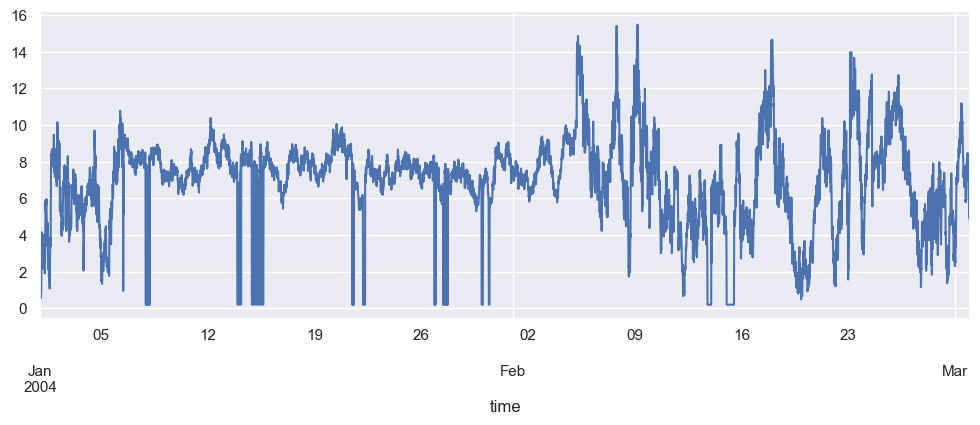

In [15]:
# plot the first 2 months of ws77 from the start of 2004

df_mast_risoe['2004-01-01':'2004-03-01']['ws77'].plot(figsize=(12,4), grid=True)
#df_mast_risoe['2004-01-01':'2004-03-01']['wd77'].plot(figsize=(12,4), grid=True)

Looking at direction, trying to figure out why it goes from 359 to 0. It is because it is a circular data mesaurement.

<Axes: xlabel='time'>

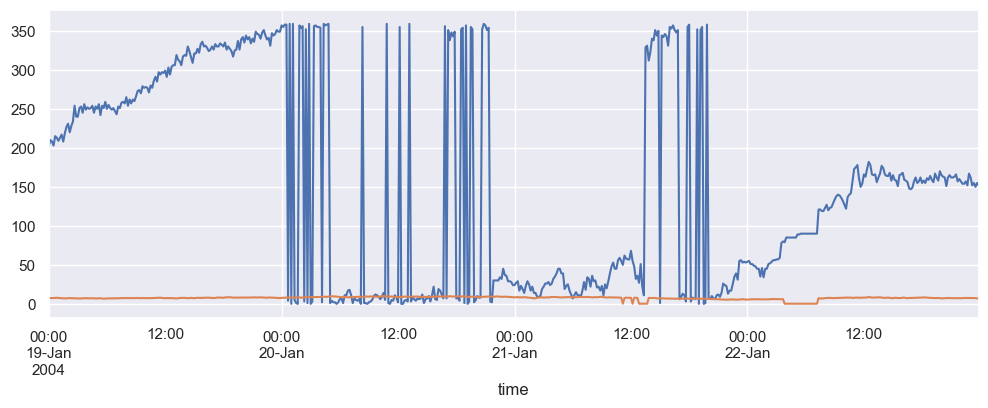

In [16]:
df_mast_risoe['2004-01-19':'2004-01-22']['wd77'].plot(figsize=(12,4), grid=True)
df_mast_risoe['2004-01-19':'2004-01-22']['ws77'].plot(figsize=(12,4), grid=True)

Some statistical information to help understand the data

In [17]:
df_mast_risoe.describe()

,ws77,wd77
count,604917.000000,604369.000000
mean,6.890057,200.628403
std,3.286966,92.255260
min,0.080000,0.000000
25%,4.580000,127.000000
50%,6.646000,215.000000
75%,8.820000,276.000000
max,32.170000,360.000000


Taking a look at outliers

In [18]:
# calculate ouliers

q1 = df_mast_risoe['ws77'].quantile(0.25)
q3 = df_mast_risoe['ws77'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
ws77_outlier_count = df_mast_risoe[(df_mast_risoe['ws77'] < lower_bound) | (df_mast_risoe['ws77'] > upper_bound)].count()['ws77']
print(f'ws77 outlier count: {ws77_outlier_count}')

ws77 outlier count: 9369


Plotting it as a boxplot to visualize the outliers

<Axes: xlabel='ws77'>

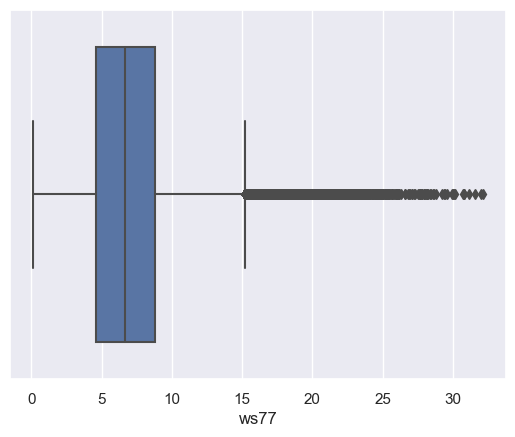

In [19]:
# do seaborn boxplot to see outliers

sns.set()
sns.boxplot(x=df_mast_risoe['ws77'])

We chose to keep the outliers since wind speed does vary a lot and it is not a measurement error.

Plotting a histogram to visualize the distribution of the data. It looks close to a Wibull-distribution.

array([[<Axes: title={'center': 'ws77'}>,
        <Axes: title={'center': 'wd77'}>]], dtype=object)

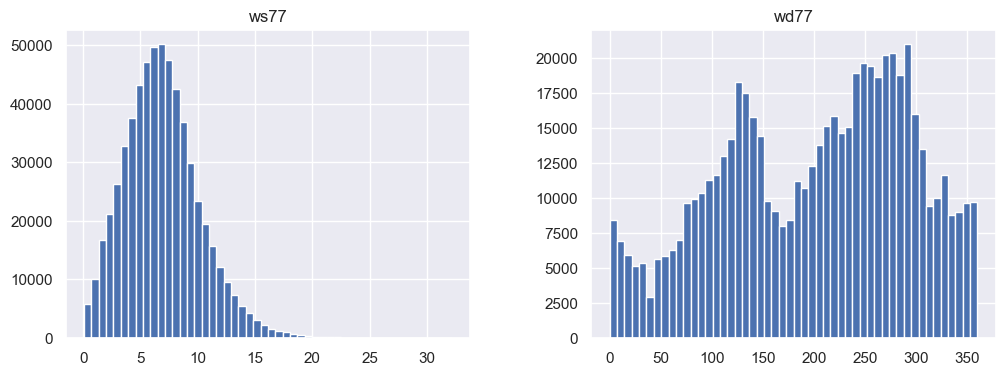

In [20]:
# show histogram of df_mast_risoe

df_mast_risoe.hist(bins=50, figsize=(12,4))

Taking a look at the time where it should switch between CET and CEST. Looks like time switch does not happen, and we do not know what strategy has been used. So we continue by subtracting 2 hours to get UTC time.

array([[<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>]], dtype=object)

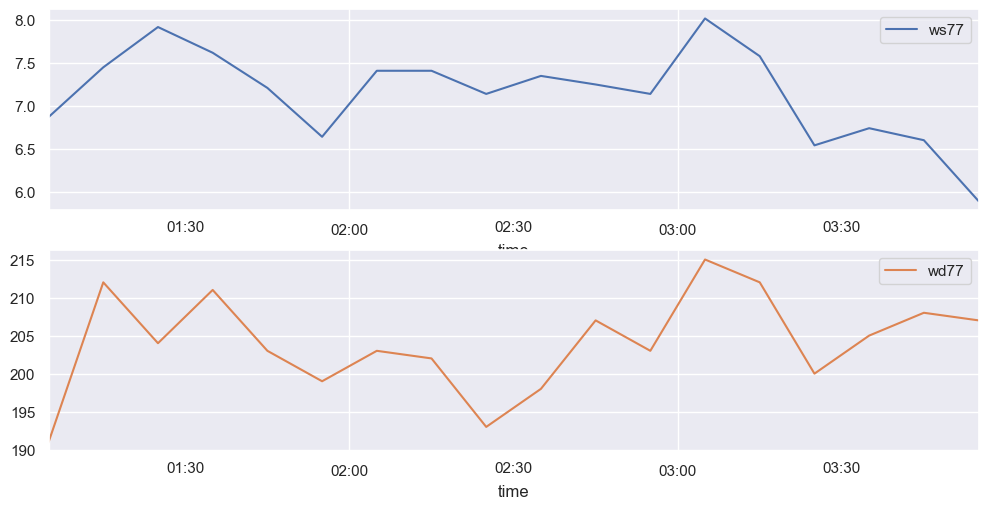

In [21]:
# plot data from 2002-12-01 to 2003-03-01

df_mast_risoe['1996-10-27 01:00':'1996-10-27 04:00'].plot(subplots=True, layout=(4,1), figsize=(12,12), sharex=False, sharey=False)

Checking for null values again

In [22]:
df_mast_risoe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604917 entries, 1995-11-20 16:25:00 to 2007-07-15 23:40:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ws77    604917 non-null  float64
 1   wd77    604369 non-null  float64
dtypes: float64(2)
memory usage: 30.0 MB


# Interpolate missing wind directions

Since there are missing wind directions we interpolate the missing values linearly.

In [23]:
# find index of nan values in wd77

nan_index = df_mast_risoe[df_mast_risoe['wd77'].isnull()].index

nan_index

DatetimeIndex(['1995-11-21 09:55:00', '1995-11-21 10:05:00',
               '1995-11-21 10:15:00', '1995-11-24 13:05:00',
               '1995-12-04 14:05:00', '1995-12-04 14:15:00',
               '1995-12-19 09:15:00', '1996-03-04 11:05:00',
               '1996-07-26 08:45:00', '1996-07-28 22:05:00',
               ...
               '2006-02-27 07:35:00', '2006-02-27 07:45:00',
               '2006-02-27 08:05:00', '2006-02-27 08:55:00',
               '2006-03-12 15:55:00', '2006-03-12 17:25:00',
               '2006-03-12 19:35:00', '2006-03-12 20:15:00',
               '2006-03-13 17:45:00', '2006-03-14 00:45:00'],
              dtype='datetime64[ns]', name='time', length=548, freq=None)

Plot data before interpolation

array([[<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>]], dtype=object)

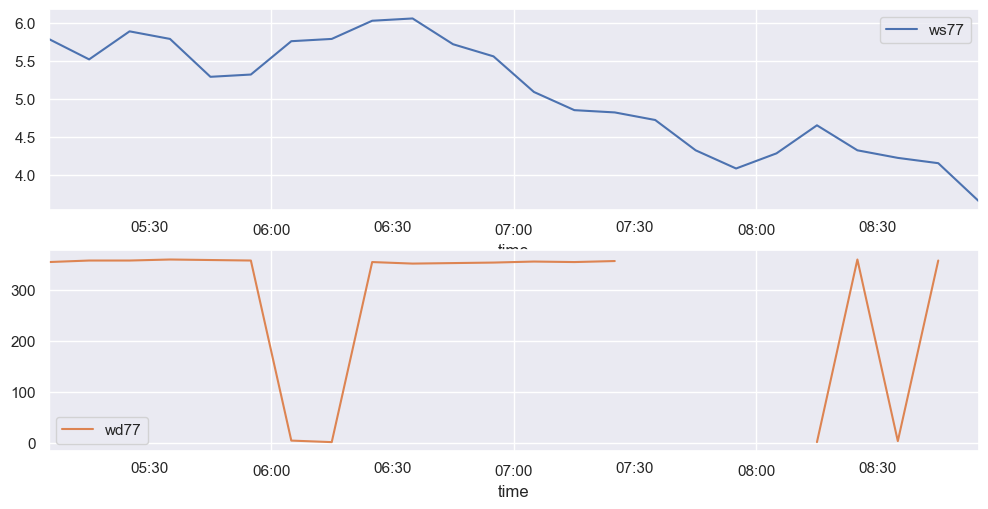

In [24]:
# plot ws77 and wd77 from 2006-02-27 07:20 to 2006-02-27 08:05

df_mast_risoe['2006-02-27 05:00':'2006-02-27 09:00'].plot(subplots=True, layout=(4,1), figsize=(12,12), sharex=False, sharey=False)

Doing linear interpolation

In [25]:
# interopolate missing wd77 values

df_mast_risoe['wd77'].interpolate(method='linear', inplace=True)

Plotting the result. Looks ok.

array([[<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>],
       [<Axes: xlabel='time'>]], dtype=object)

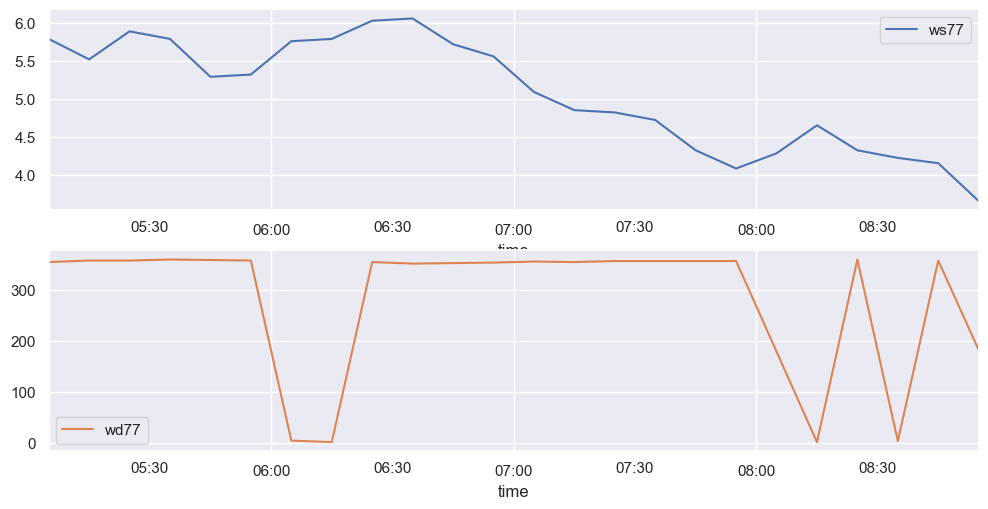

In [26]:
# plot ws77 and wd77 from 2006-02-27 07:20 to 2006-02-27 08:05

df_mast_risoe['2006-02-27 05:00':'2006-02-27 09:00'].plot(subplots=True, layout=(4,1), figsize=(12,12), sharex=False, sharey=False)

# Scale data

Time to scale the data, since linear regression works best with scaled data. We use a min max scaler to keep the outliers as part of the scale, to not change the distribution.

array([[<Axes: title={'center': 'ws77'}>,
        <Axes: title={'center': 'wd77'}>]], dtype=object)

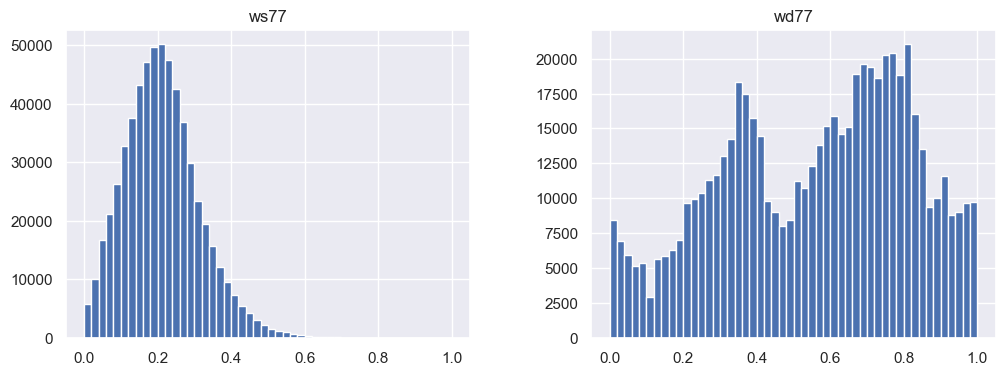

In [27]:
scaled_df_mast_risoe = pd.DataFrame(MinMaxScaler().fit_transform(df_mast_risoe), columns=df_mast_risoe.columns, index=df_mast_risoe.index)

scaled_df_mast_risoe.hist(bins=50, figsize=(12,4))

# Convert to UTC time


Original data does not account for daylight savings time. So we have to remove 2 hours from the times manually.

In [28]:
# remove 2 hours from the time index

scaled_df_mast_risoe.index = scaled_df_mast_risoe.index - timedelta(hours=2)

scaled_df_mast_risoe.head()

,ws77,wd77
time,,
1995-11-20 14:25:00,0.102213,0.569444
1995-11-20 14:35:00,0.092552,0.569444
1995-11-20 14:45:00,0.109380,0.566667
1995-11-20 14:55:00,0.118105,0.561111
1995-11-20 15:05:00,0.145217,0.558333


# Resample mast data

First we resample wind speed into a new dataframe column.

In [29]:
resampled_scaled_mast_risoe = pd.DataFrame()

# resample the ws77 data to 1 hour intervals 
resampled_scaled_mast_risoe['ws77'] = scaled_df_mast_risoe['ws77'].resample('1H').mean()


resampled_scaled_mast_risoe.dropna(inplace=True)
resampled_scaled_mast_risoe.head()

,ws77
time,
1995-11-20 14:00:00,0.105562
1995-11-20 15:00:00,0.160071
1995-11-20 16:00:00,0.193466
1995-11-20 17:00:00,0.225512
1995-11-20 18:00:00,0.245040


Plot it to see if it looks correct.

array([[<Axes: xlabel='time'>]], dtype=object)

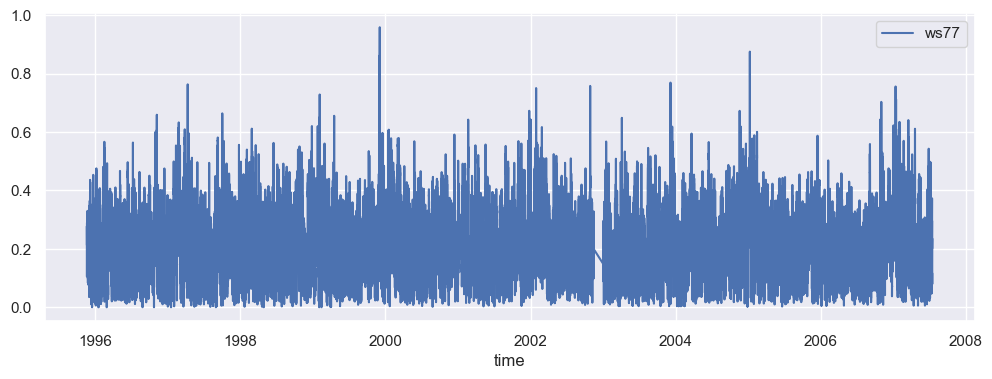

In [30]:
# plot resampled_scaled_mast_risoe

resampled_scaled_mast_risoe.plot(subplots=True, layout=(1,1), figsize=(12,4), sharex=False, sharey=False)

To resample the wind direction we have to use a different approach since it is circular data. We use the mean of the sin and cos of the wind direction to get the mean direction.

First we create a helpe function

In [31]:
# Steps:
#  Convert the wind direction in degrees to radians.
#  Convert the radians to unit vectors.
#  Calculate the mean vector of the unit vectors.
#  Convert the mean vector back to degrees.

def mean_wind_direction(degrees_series):
    radians_series = np.radians(degrees_series)
    unit_vectors = np.column_stack((np.cos(radians_series), np.sin(radians_series)))
    mean_vector = np.mean(unit_vectors, axis=0)
    mean_direction_degrees = np.degrees(np.arctan2(mean_vector[1], mean_vector[0]))
    return mean_direction_degrees

We then use it to resample the wind direction

In [32]:
resampled_scaled_mast_risoe['wd77'] = scaled_df_mast_risoe.resample('1H').agg({'wd77':mean_wind_direction})

resampled_scaled_mast_risoe.head()

C:\Users\Maggie\PycharmProjects\MAL\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Maggie\PycharmProjects\MAL\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,ws77,wd77
time,,
1995-11-20 14:00:00,0.105562,0.566667
1995-11-20 15:00:00,0.160071,0.558333
1995-11-20 16:00:00,0.193466,0.563426
1995-11-20 17:00:00,0.225512,0.556019
1995-11-20 18:00:00,0.245040,0.548611


Checking the result for any mistakes

In [33]:
resampled_scaled_mast_risoe.info()
resampled_scaled_mast_risoe.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100827 entries, 1995-11-20 14:00:00 to 2007-07-15 21:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ws77    100827 non-null  float64
 1   wd77    100827 non-null  float64
dtypes: float64(2)
memory usage: 2.3 MB


Plotting the final resampled data to visualize and check it.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

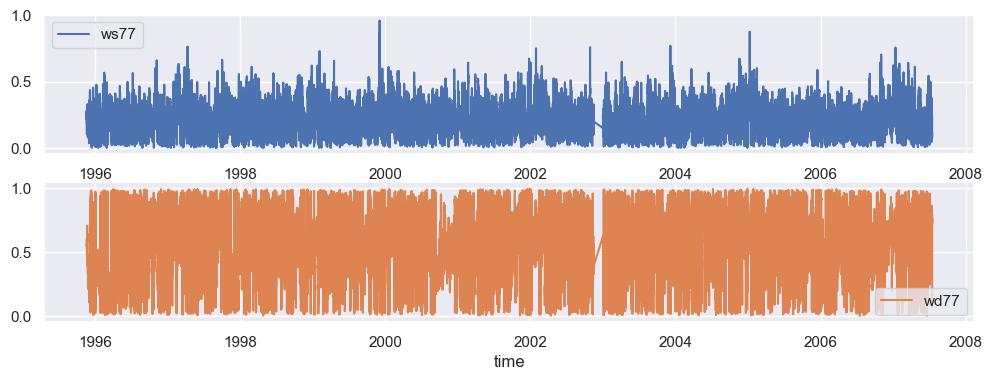

In [34]:
# plot resampled_scaled_mast_risoe

resampled_scaled_mast_risoe.plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

# Load MESO Data

Time to load the MESO data. Chosing to only load the data that is needed, to reduce memory usage.

In [35]:
# only load TIMESTAMP WSP060 WSP080 WDIR060 WDIR080
# convert TIMESTAMP to datetime and use it as index

meso_risoe = pd.read_csv('Data/Risoe/meso_Risoe.csv', usecols=['TIMESTAMP', 'WSP060', 'WSP080', 'WDIR060', 'WDIR080'], parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')


# sort dataframe by index
meso_risoe.sort_index(inplace=True)

meso_risoe.head()

,WSP060,WSP080,WDIR060,WDIR080
TIMESTAMP,,,,
2000-01-01 07:00:00,5.40,5.83,208.02,209.09
2000-01-01 08:00:00,5.67,6.13,203.13,204.21
2000-01-01 09:00:00,6.12,6.69,203.82,204.75
2000-01-01 10:00:00,5.84,6.37,210.63,211.50
2000-01-01 11:00:00,5.56,6.20,216.27,217.37


Plotting data to visualize it.

array([<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
      dtype=object)

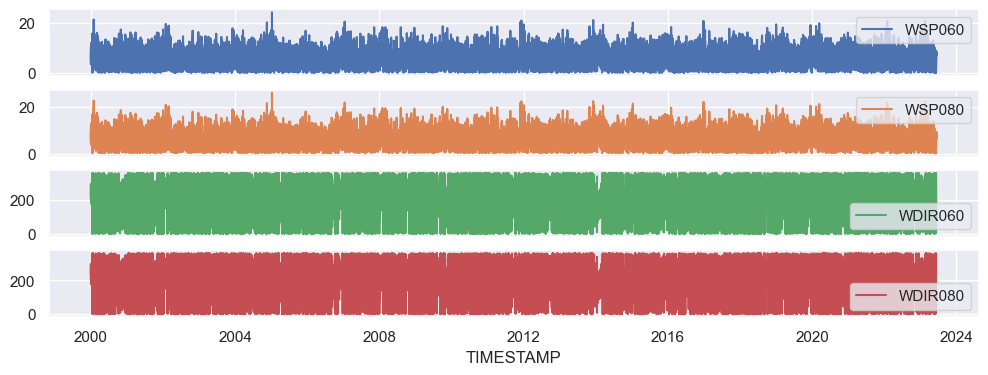

In [36]:
# plot meso_risoe
meso_risoe.plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

# Only use overlapping time period

Time to slice the data to only use the overlapping data from mast and MESO.

The loaded MESO data was originally not sorted by time, had some issues with it, but eventually figured it out, sorted it and slicing went fine.

In [37]:
resampled_scaled_mast_risoe.index[0], resampled_scaled_mast_risoe.index[-1]

(Timestamp('1995-11-20 14:00:00'), Timestamp('2007-07-15 21:00:00'))

In [38]:
meso_risoe.index[0], meso_risoe.index[-1]

(Timestamp('2000-01-01 07:00:00'), Timestamp('2023-06-11 06:00:00'))

array([<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>],
      dtype=object)

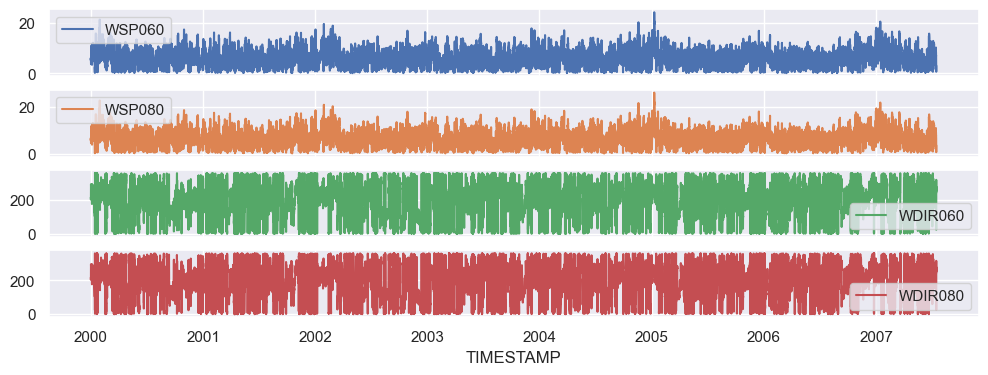

In [39]:
# slice meso_risoe to only include until the last index of resampled_scaled_mast_risoe
last_index = resampled_scaled_mast_risoe.index[-1]
meso_risoe_overlap = meso_risoe[:str(last_index)]


# plot overlap

meso_risoe_overlap.plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

In [40]:
meso_risoe.index[0], meso_risoe.index[-1]

(Timestamp('2000-01-01 07:00:00'), Timestamp('2023-06-11 06:00:00'))

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>], dtype=object)

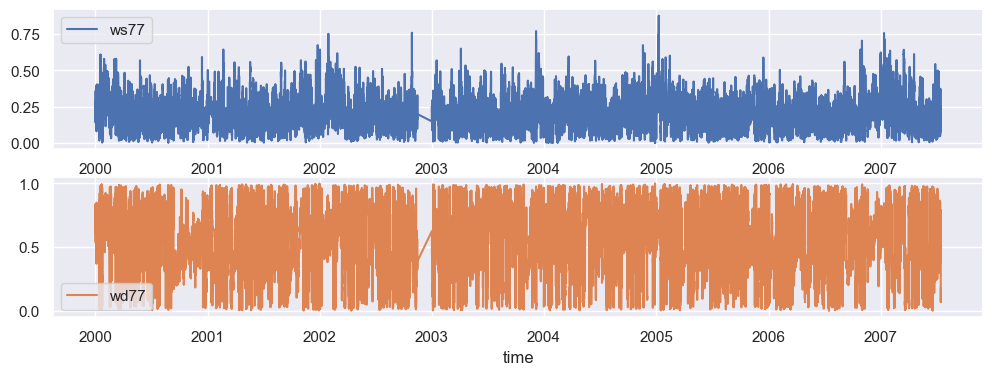

In [41]:
# slice resampled_scaled_mast_risoe to only include from the first index of meso_risoe_overlap

resampled_scaled_mast_risoe_overlap = resampled_scaled_mast_risoe[meso_risoe.index[0]:]

# plot overlap

resampled_scaled_mast_risoe_overlap.plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

# Interpolate the wind speed height

We chose to try and interpolate the height to 77 for the MESO data. The plotting the difference between the interpolated WSP077 and the original WSP080 to see how big of a difference there is. In the end the difference is so small that interpolation is not needed.

C:\Users\Maggie\AppData\Local\Temp\ipykernel_23020\3881799312.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meso_risoe_overlap['WS077'] = (meso_risoe_overlap['WSP060'] * w_WS060) + (meso_risoe_overlap['WSP080'] * w_WS080)


array([<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>], dtype=object)

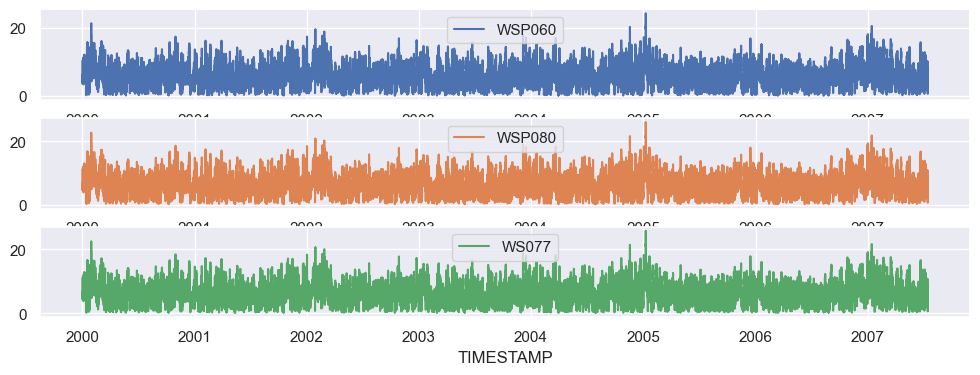

In [42]:
target_height = 77

# Calculate the interpolation weight for WS060 and WS080
w_WS060 = (80 - target_height) / (80 - 60)
w_WS080 = (target_height - 60) / (80 - 60)

# Linearly interpolate WS060 and WS080 to WS077
meso_risoe_overlap['WS077'] = (meso_risoe_overlap['WSP060'] * w_WS060) + (meso_risoe_overlap['WSP080'] * w_WS080)

# plot WS060 WS080 and WS077
meso_risoe_overlap[['WSP060', 'WSP080', 'WS077']].plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

<Axes: xlabel='TIMESTAMP'>

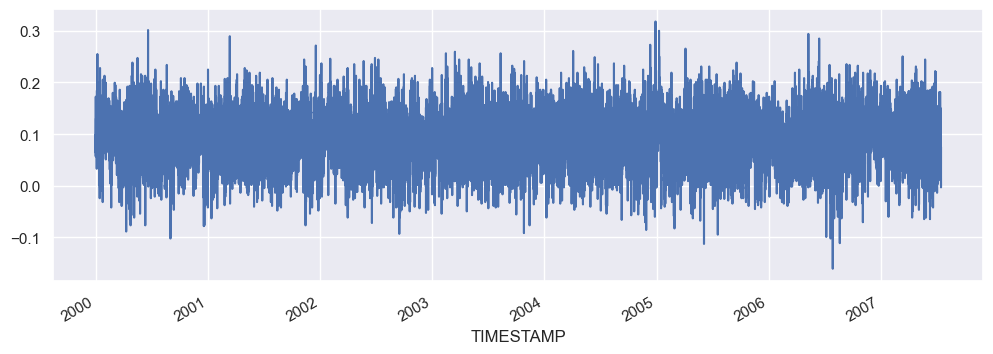

In [43]:
# plot the difference between WSP080 and WS077
(meso_risoe_overlap['WSP080'] - meso_risoe_overlap['WS077']).plot(figsize=(12,4), grid=True)

# Interpolate the wind direction height 77

In [44]:
# Interpolation target height
target_height = 77

# calculate the interpolated wind direction as an angle weighted average of WDIR060 and WDIR080
# first convert the angles to radians
# then calculate the interpolation weight for WDIR060 and WDIR080
# then calculate the angle weighted average of WDIR060 and WDIR080

meso_risoe_overlap['WDIR060_rad'] = np.radians(meso_risoe_overlap['WDIR060'])
meso_risoe_overlap['WDIR080_rad'] = np.radians(meso_risoe_overlap['WDIR080'])

w_WDIR060 = (80 - target_height) / (80 - 60)
w_WDIR080 = (target_height - 60) / (80 - 60)

meso_risoe_overlap['WDIR077'] = (meso_risoe_overlap['WDIR060_rad'] * w_WDIR060) + (meso_risoe_overlap['WDIR080_rad'] * w_WDIR080)

# convret from radians to degrees

meso_risoe_overlap['WDIR077'] = np.degrees(meso_risoe_overlap['WDIR077'])

C:\Users\Maggie\AppData\Local\Temp\ipykernel_23020\3492755142.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meso_risoe_overlap['WDIR060_rad'] = np.radians(meso_risoe_overlap['WDIR060'])
C:\Users\Maggie\AppData\Local\Temp\ipykernel_23020\3492755142.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meso_risoe_overlap['WDIR080_rad'] = np.radians(meso_risoe_overlap['WDIR080'])
C:\Users\Maggie\AppData\Local\Temp\ipykernel_23020\3492755142.py:15: SettingWithCopyWarning: 
A value is trying to be set on a 

array([<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>], dtype=object)

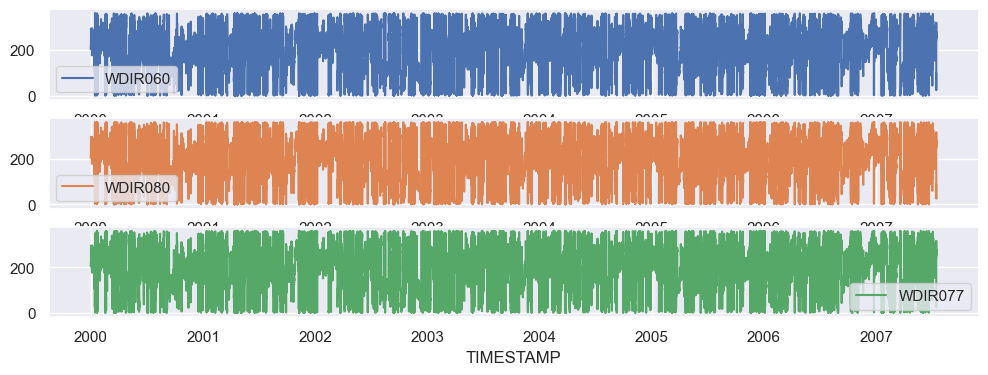

In [45]:
meso_risoe_overlap[['WDIR060', 'WDIR080', 'WDIR077']].plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

<Axes: xlabel='TIMESTAMP'>

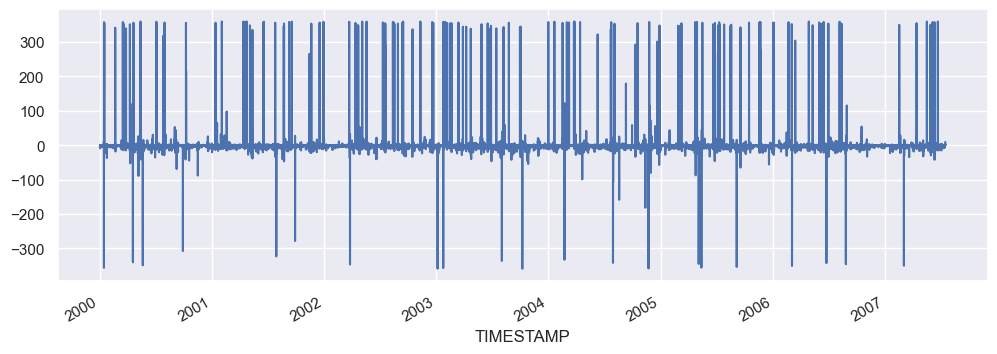

In [46]:
# plot the difference bewteen WDIR060 and WDIR080  

(meso_risoe_overlap['WDIR060'] - meso_risoe_overlap['WDIR080']).plot(figsize=(12,4), grid=True)

<Axes: xlabel='TIMESTAMP'>

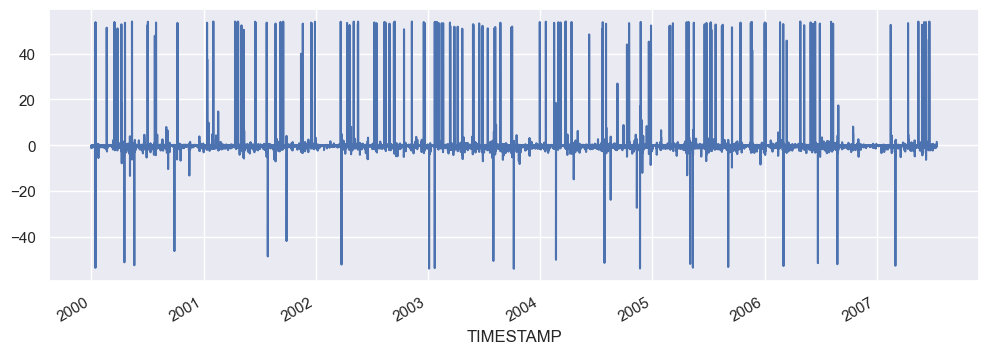

In [47]:
# plot the difference between WDIR077 and WDIR080

(meso_risoe_overlap['WDIR077'] - meso_risoe_overlap['WDIR080']).plot(figsize=(12,4), grid=True)

# Check for correlation between mast and meso data

We join all the data together into one dataframe, and then check for correlation between the different columns.

In [48]:
# join the two dataframes together

joined_df = pd.concat([resampled_scaled_mast_risoe_overlap, meso_risoe_overlap[['WS077', 'WDIR077']]], axis=1)

joined_df.dropna(inplace=True)

joined_df.head()

,ws77,wd77,WS077,WDIR077
2000-01-01 07:00:00,0.190817,0.539352,5.7655,208.9295
2000-01-01 08:00:00,0.206347,0.561111,6.0610,204.0480
2000-01-01 09:00:00,0.219383,0.545833,6.6045,204.6105
2000-01-01 10:00:00,0.201361,0.558333,6.2905,211.3695
2000-01-01 11:00:00,0.212268,0.555093,6.1040,217.2050


In [49]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64714 entries, 2000-01-01 07:00:00 to 2007-07-15 21:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ws77     64714 non-null  float64
 1   wd77     64714 non-null  float64
 2   WS077    64714 non-null  float64
 3   WDIR077  64714 non-null  float64
dtypes: float64(4)
memory usage: 2.5 MB


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

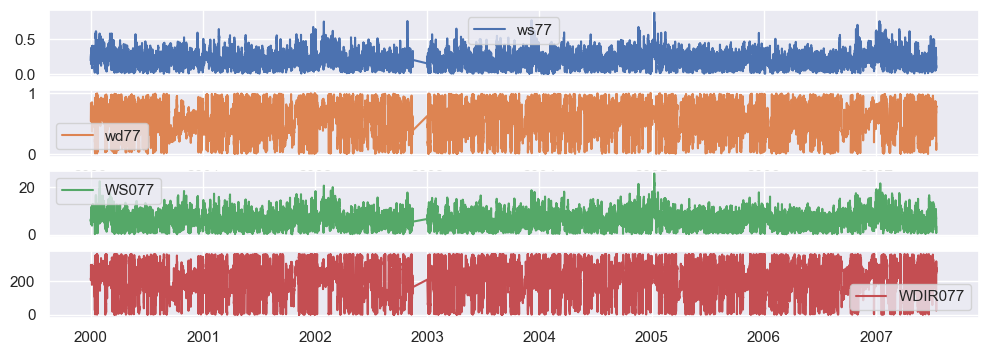

In [50]:
# plot joined_df

joined_df.plot(subplots=True, figsize=(12,4), sharex=False, sharey=False)

<Axes: >

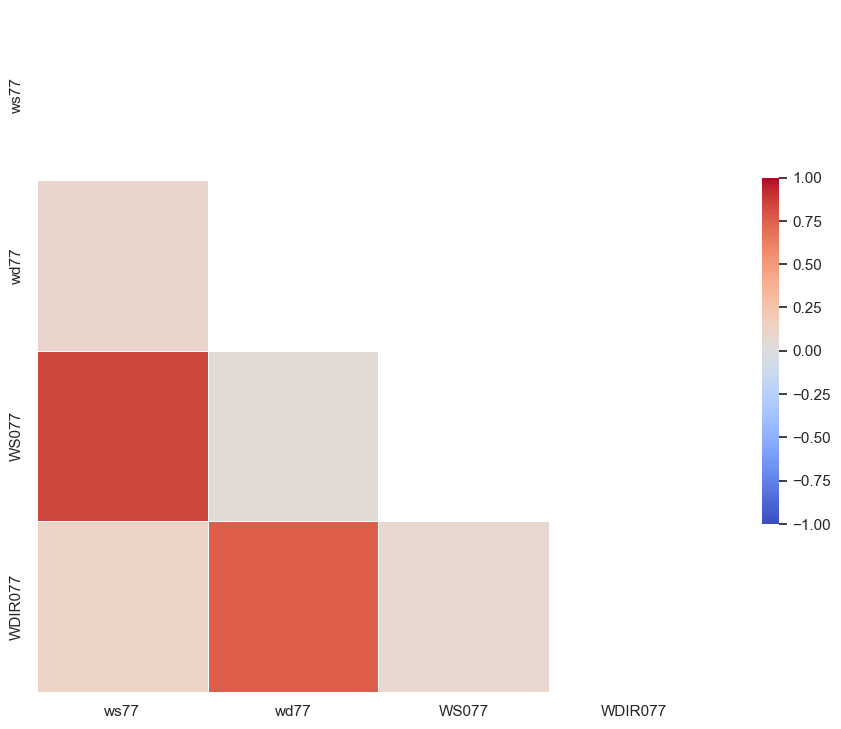

In [53]:
# Generate upper right triangle correlation matrix plot

sns.set(style="white")
corr = joined_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Weibull-Distribution

We plot the data to check how close it matches the Weibull-Distribution.

array([[<Axes: title={'center': 'ws77'}>,
        <Axes: title={'center': 'wd77'}>],
       [<Axes: title={'center': 'WS077'}>,
        <Axes: title={'center': 'WDIR077'}>]], dtype=object)

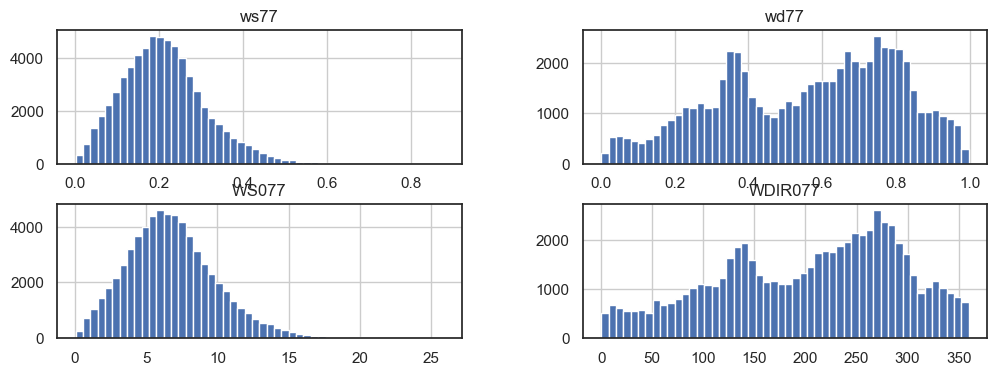

In [54]:
# plot histogram

joined_df.hist(bins=50, figsize=(12,4))

As we can see, the data follows the Weibull distribution quite well, as it should for wind speed. Thus, the decision of not removing the outliers seems to be correct. If we had removed them, the distribution would have changed and not follow Weibull anymore. 

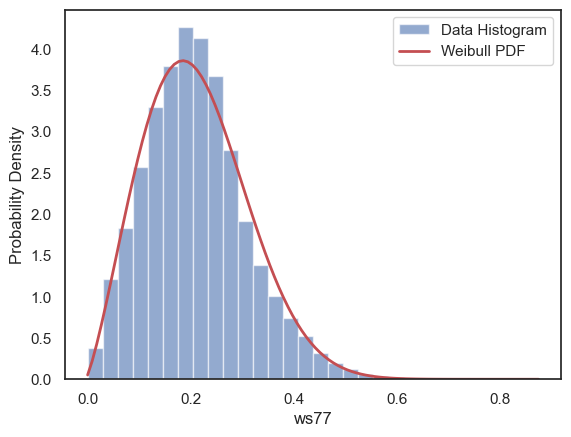

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Fit a Weibull distribution to the data
params = weibull_min.fit(joined_df['ws77'])

# Create a histogram of the data
plt.hist(joined_df['ws77'], bins=30, density=True, alpha=0.6, label='Data Histogram')

# Create a range of x values for the Weibull PDF
x = np.linspace(0, joined_df['ws77'].max(), 100)

# Calculate the Weibull PDF using the fitted parameters
pdf = weibull_min.pdf(x, *params)

# Plot the Weibull PDF on top of the histogram
plt.plot(x, pdf, 'r-', lw=2, label='Weibull PDF')

# Add labels and a legend
plt.xlabel('ws77')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()

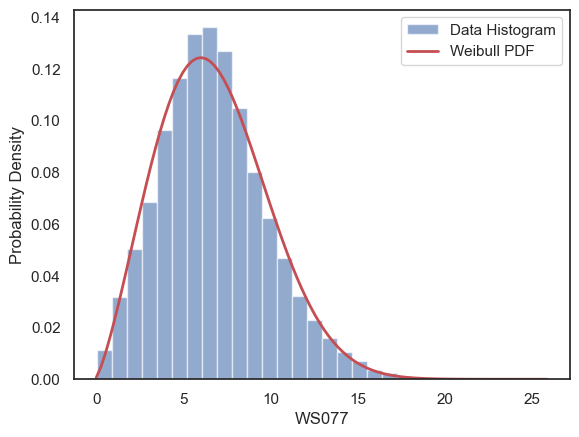

In [56]:
# Fit a Weibull distribution to the data
params = weibull_min.fit(joined_df['WS077'])

# Create a histogram of the data
plt.hist(joined_df['WS077'], bins=30, density=True, alpha=0.6, label='Data Histogram')

# Create a range of x values for the Weibull PDF
x = np.linspace(0, joined_df['WS077'].max(), 100)

# Calculate the Weibull PDF using the fitted parameters
pdf = weibull_min.pdf(x, *params)

# Plot the Weibull PDF on top of the histogram
plt.plot(x, pdf, 'r-', lw=2, label='Weibull PDF')

# Add labels and a legend
plt.xlabel('WS077')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()

# Introduce month based features

To ensure that the training and test data is distributed over all of the seasons, we did one hot encoding by months. 

In [57]:
# do one hot encoding on joined_df.index, where the index is used to make columns based on the month in index.
# the month columns should be named 01-12

one_hot_encoded_df = pd.get_dummies(joined_df.index.month, prefix='month')

# change index of one_hot_encoded_df to joined_df.index

one_hot_encoded_df.index = joined_df.index

# join them together

joined_month_df = pd.concat([joined_df, one_hot_encoded_df], axis=1)

joined_month_df.head()


,ws77,wd77,WS077,WDIR077,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2000-01-01 07:00:00,0.190817,0.539352,5.7655,208.9295,True,False,False,False,False,False,False,False,False,False,False,False
2000-01-01 08:00:00,0.206347,0.561111,6.0610,204.0480,True,False,False,False,False,False,False,False,False,False,False,False
2000-01-01 09:00:00,0.219383,0.545833,6.6045,204.6105,True,False,False,False,False,False,False,False,False,False,False,False
2000-01-01 10:00:00,0.201361,0.558333,6.2905,211.3695,True,False,False,False,False,False,False,False,False,False,False,False
2000-01-01 11:00:00,0.212268,0.555093,6.1040,217.2050,True,False,False,False,False,False,False,False,False,False,False,False


In [58]:
# count number of 1 in each month column

joined_month_df.iloc[:, -12:].sum()

month_1     5945
month_2     5424
month_3     5952
month_4     5760
month_5     5794
month_6     5712
month_7     5551
month_8     5208
month_9     5040
month_10    5208
month_11    4654
month_12    4466
dtype: int64

# Model Development

Splitting the data into train and test sets + stradified random sampling based to months of the year to ensure equal distrubution over the seasons. We put two features into y to predict both wind speed and wind direction. 

In [59]:
# splitting the data into training and test
# we want the represeantation of seasons to be equaled out
# we decided to use stratified random sampling based on months of the year

X = joined_month_df[['ws77', 'wd77', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
y = joined_month_df[['WS077', 'WDIR077']]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=56,
    stratify=joined_month_df[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
)

## Ordinary least squares

In [60]:
# ordinary least squares

OLS_model = LinearRegression()  
OLS_model.fit(X_train, y_train)

print("R2 on train data: " + str(OLS_model.score(X_train, y_train)))
print("R2 on test data: " + str(OLS_model.score(X_test, y_test)))

print("MSE on train data: " + str(mean_squared_error(y_train, OLS_model.predict(X_train))))
print("MSE on test data: " + str(mean_squared_error(y_test, OLS_model.predict(X_test))))

print("RMSE on train data: " + str(math.sqrt(mean_squared_error(y_train, OLS_model.predict(X_train)))))
print("RMSE on test data: " + str(math.sqrt(mean_squared_error(y_test, OLS_model.predict(X_test)))))

y_pred = OLS_model.predict(X_test)
print("MAE: " + str(mean_absolute_error(y_test, y_pred)))
print("Explained variance: " + str(explained_variance_score(y_test, y_pred)))

R2 on train data: 0.6395841023541496
R2 on test data: 0.6360808716529
MSE on train data: 1707.7193875217442
MSE on test data: 1748.4006564354936
RMSE on train data: 41.32456155268613
RMSE on test data: 41.81388114532653
MAE: 16.894834311077865
Explained variance: 0.636190345664663


## Elastic net with CV

Finding the best parameters for the elastic net model using grid search and cross validation.

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'l1_ratio': [0.1, 0.5, 0.9],
    'fit_intercept': [True, False],
    'max_iter': [100, 500, 1000] 
}

grid_search = GridSearchCV(ElasticNet(), param_grid, cv=10)

grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_en_model = grid_search.best_estimator_

# print all best variables

print("Best alpha: " + str(best_alpha))
print("Best l1_ratio: " + str(best_l1_ratio))
print("Best model: " + str(best_en_model))

Best alpha: 0.1
Best l1_ratio: 0.9
Best model: ElasticNet(alpha=0.1, fit_intercept=False, l1_ratio=0.9, max_iter=100)


In [62]:
print("R2 on train data: " + str(best_en_model.score(X_train, y_train)))
print("R2 on test data: " + str(best_en_model.score(X_test, y_test)))

print("MSE on train data: " + str(mean_squared_error(y_train, best_en_model.predict(X_train))))
print("MSE on test data: " + str(mean_squared_error(y_test, best_en_model.predict(X_test))))

print("RMSE on train data: " + str(math.sqrt(mean_squared_error(y_train, best_en_model.predict(X_train)))))
print("RMSE on test data: " + str(math.sqrt(mean_squared_error(y_test, best_en_model.predict(X_test)))))

y_pred = best_en_model.predict(X_test)
print("MAE: " + str(mean_absolute_error(y_test, y_pred)))
print("Explained variance: " + str(explained_variance_score(y_test, y_pred)))

R2 on train data: 0.48443357950629434
R2 on test data: 0.48069396789479696
MSE on train data: 1724.0377963589733
MSE on test data: 1769.000069935833
RMSE on train data: 41.521534128196336
RMSE on test data: 42.05948252101817
MAE: 17.783929809719343
Explained variance: 0.5103531680306673


# kNN

In [63]:
y1 = y['WS077']
y2 = y['WDIR077']

# Split the data into training and testing sets
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X, 
    y1,
    y2, 
    test_size=0.2, 
    random_state=56,
    stratify=joined_month_df[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]
)

In [64]:
# Create a k-NN classifier
knn = KNeighborsRegressor()

# Define a parameter grid for grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 21, 51, 101, 151, 201],  # Adjust the number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

In [65]:
# Create a GridSearchCV object for the first target variable (y1)
grid_search_y1 = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to your training data for the first target variable (y1)
grid_search_y1.fit(X_train, y1_train)

# Get the best hyperparameters and estimator for y1
best_params_y1 = grid_search_y1.best_params_
best_estimator_y1 = grid_search_y1.best_estimator_

# Create a GridSearchCV object for the second target variable (y2)
grid_search_y2 = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to your training data for the second target variable (y2)
grid_search_y2.fit(X_train, y2_train)

# Get the best hyperparameters and estimator for y2
best_params_y2 = grid_search_y2.best_params_
best_estimator_y2 = grid_search_y2.best_estimator_

# Predict using the best estimator for the first target variable (y1)
y1_pred = best_estimator_y1.predict(X_test)

# Calculate mean squared error and R-squared for y1
mse_y1 = mean_squared_error(y1_test, y1_pred)
r2_y1 = r2_score(y1_test, y1_pred)

# Predict using the best estimator for the second target variable (y2)
y2_pred = best_estimator_y2.predict(X_test)

# Calculate mean squared error and R-squared for y2
mse_y2 = mean_squared_error(y2_test, y2_pred)
r2_y2 = r2_score(y2_test, y2_pred)

# Print the regression metrics for both target variables
print("Metrics for Target Variable y1:")
print(f"Best Hyperparameters: {best_params_y1}")
print(f"Mean Squared Error: {mse_y1}")
print(f"R-squared: {r2_y1}")

print("\nMetrics for Target Variable y2:")
print(f"Best Hyperparameters: {best_params_y2}")
print(f"Mean Squared Error: {mse_y2}")
print(f"R-squared: {r2_y2}")

Metrics for Target Variable y1:
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 51, 'weights': 'distance'}
Mean Squared Error: 2.537769542580155
R-squared: 0.7326691797238706

Metrics for Target Variable y2:
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 101, 'weights': 'distance'}
Mean Squared Error: 3143.3071793233485
R-squared: 0.6006919649402351


## Conclusion of results of models

The worst performing one was the Elastic net with R2 with only 0.48. 
The Ordinary least squares performed better with R2 of 0.64. 
For kNN we chose to predict the speed and direction of the wind separately. The best performing one was the kNN for wind speed with R2 of 0.73. The one for wind direction performed worse with R2 of 0.60.

Regarding the MSE, all the models got result in thousands, except for the best performing one, kNN for wind speed with MSE of only 2.54. This is a very good result, compared to the others. Considering, that all the other models were estimating both wind speed and wind direction, when averaging the MSE for kNN of both, the result is comparable with Elastic net and Ordinary least squares.

To conclude, regression models might not be good enough to predict both wind direction and wind speed and neural network or similar might be a better choice. However, if we only want to predict wind speed, kNN is a good option.